# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
import functools
from itertools import repeat
from typing import NoReturn

### 1. Данные (0.5 балла)


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw1/hw1/ml-intro/hw_knn_data/cancer.csv'

In [3]:
def read_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    df_shuffled = df.sample(frac=1, random_state=102)
    return np.array(df_shuffled.drop('label', 1)), np.array(df_shuffled['label'])

def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    X, y = read_dataset(path_to_csv)
    label2num = lambda x: 1 if x == 'M' else 0 
    y = np.array([label2num(yi) for yi in y])
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [5]:
def get_size_dataframe(X):
    return len(X.index)

In [6]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    size_train = (int)(np.size(X, axis=0) * ratio)
    
    X_train = X[: size_train]
    y_train = y[: size_train]
    
    X_test = X[size_train :]
    y_test = y[size_train : ]

    return X_train, y_train, X_test, y_test

### 2. Метрики (0.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [7]:
def get_tn_tp_fp_fn(y_pred, y_true, label):
    TN, TP, FP, FN = 0, 0, 0, 0
    for i in range(len(y_pred)): 
        if y_true[i] == y_pred[i] == label: 
            TP += 1
        if y_pred[i] == label and y_true[i] != y_pred[i]:
            FP += 1
        if y_true[i] == y_pred[i] != label:
            TN += 1
        if y_pred[i] != label and y_true[i] != y_pred[i]:
            FN += 1
    return TN, TP, FP, FN


def get_precision_recall_for_label(y_pred: np.array, y_true: np.array, label):
    """
    
    Returns
    -----
    precision, recall, accuracy : tuple of numbers (precision, recall) for given label
    """
    
    TN, TP, FP, FN = get_tn_tp_fp_fn(y_pred, y_true, label)
    if (TP + FP) == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    if (TP + FN) == 0:
        recall = 0
    else:
        recall = TP / (TP + FN) 

    return precision, recall

# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания

    all_vals = np.concatenate((np.array(y_true), np.array(y_pred))).astype("int")
    labels = np.unique(all_vals, axis=0)
    precision_recall = np.array(list(
        map(get_precision_recall_for_label, repeat(y_pred), repeat(y_true), labels)))
    precision = precision_recall.T[1]
    recall = precision_recall.T[0]
    
    eq_y_pred_and_y_true = y_true == y_pred
    positive_ans = eq_y_pred_and_y_true[eq_y_pred_and_y_true].size
    accuracy = positive_ans / np.size(y_pred, axis=0)
    return precision, recall, accuracy

#     classes = np.unique(list(y_train) + list(y_true))
#     precisions = [precision_score(y_pred, y_true, pos_label=cls) for cls in classes]
#     recalls = [recall_score(y_pred, y_true, pos_label=cls) for cls in classes]
#     accuracies = [accuracy_score(y_pred, y_true) for cls in classes]
#     return precisions, recalls, accuracies

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [8]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, np.array(y_test))
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [9]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
#         for (t, f) in zip(tpr, fpr):
#             if t > 0.93 and f < 0.3:
#                 print(t, f, k)
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

## 3. KNN (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [10]:
from sklearn.neighbors import KDTree


class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X, y):
        self.tree = KDTree(X, self.leaf_size)
        self.y = y
        self.labels = np.unique(y)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, 
        # а столбцы - классам. На пересечении строки и столбца должна быть указана
        # вероятность того, что элемент относится к классу
        
        # Вероятность рассчитывается как количество ближайших соседей с данным
        # классом деленное на общее количество соседей
        _, inds_nearest = self.tree.query(X, self.n_neighbors)
        prob_lam = lambda label, ns: (self.y[ns])[self.y[ns] == label].size / self.n_neighbors
        probs = np.zeros((self.labels.size, X.shape[0]))
        for (i, label) in enumerate(self.labels):
            probs[i] = np.array(list(map(functools.partial(prob_lam, label), inds_nearest)))
        return probs.T    
        
        
    def predict(self, X): 
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на датасете _cancer_

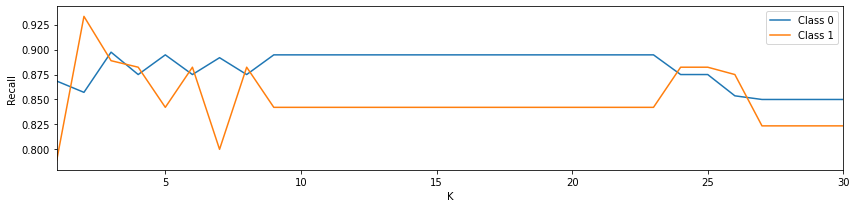

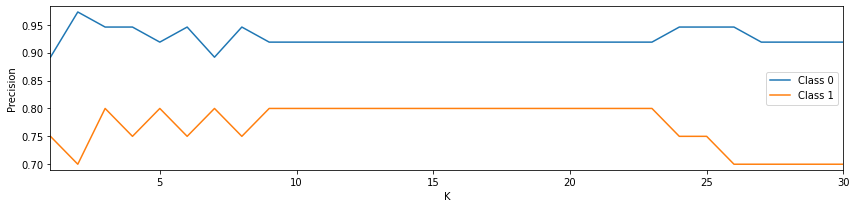

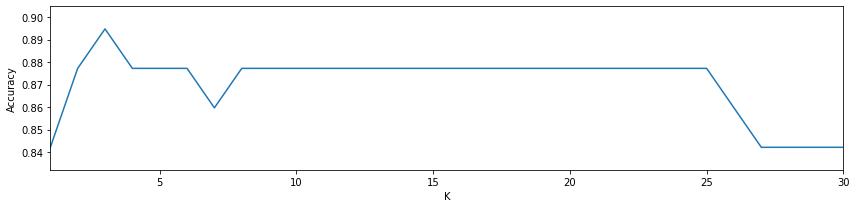

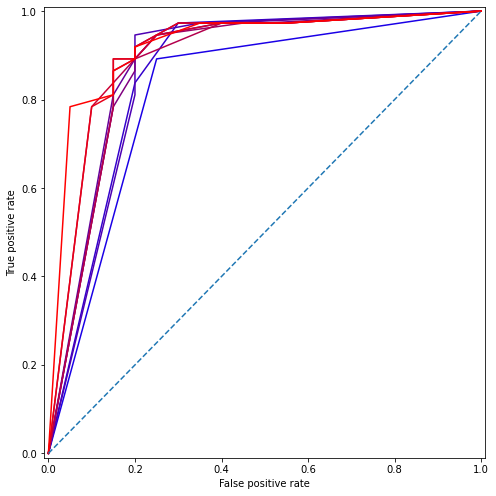

In [11]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)



Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

_Ваш ответ:_ На мой взгляд, лучше всего качество модели отражает roc-кривая, т.к. на ней легче всего найти баланс между `TPR` и `FPR`, тем самым определить параметры оптимальные модели. Так, при `k=3` `TPR`=0.95, `FPR`=0.25, что является самым лучшим показателем по их соотношению.  

## Clustering (7 баллов)

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [12]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [13]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

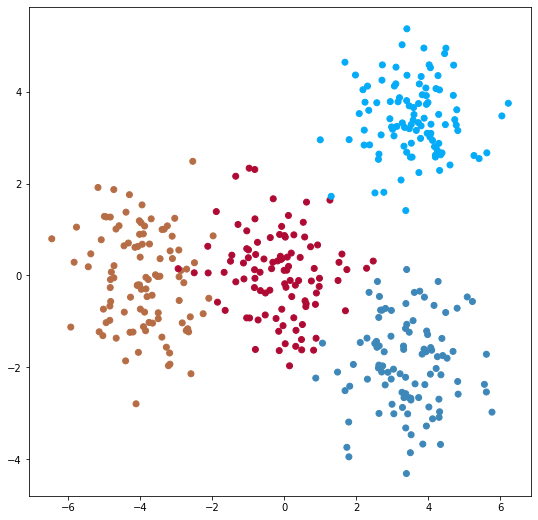

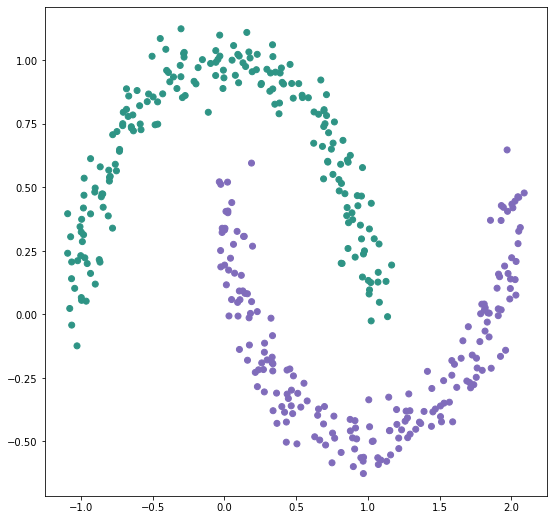

In [14]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### 1. K-means (2.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [15]:
def find_nearest(arr, value):
  """
  Returns index of array of nearest to value number
  """
  arr = np.asarray(arr)
  idx = (np.abs(arr - value)).argmin()
  return idx


class KMeans:

    def __init__(self, n_clusters: int, init: str = "random",
                 max_iter: int = 300):
        """

        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.

        """

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.init = init

    def _get_center_mass(self, points):
        return np.average(points, axis=0)

    def _get_min_distance_before_centroids(self, centroids, X):
        predicted_classes = np.zeros(np.size(X, axis=0))
        for idx, point in enumerate(X):
            distances_before_centroids = np.linalg.norm(point - centroids, axis=1)
            class_of_point = np.argmin(distances_before_centroids)
            predicted_classes[idx] = class_of_point

        return np.array(predicted_classes, dtype=int)

    def _get_predicted_classes(self, centroids, X):
        """
        Returns pair (predicted_classes, summary distance)
        """
        predicted_classes = np.zeros(np.size(X, axis=0))
        sum_distance = 0
        for idx, point in enumerate(X):
            distances_before_centroids = np.linalg.norm(point - centroids, axis=1)
            class_of_point = np.argmin(distances_before_centroids)
            sum_distance += distances_before_centroids[class_of_point]
            predicted_classes[idx] = class_of_point

        return np.array(predicted_classes, dtype=int), sum_distance

    def calc_class_of_points(self, centroids, X):
        """
        Returns pair (classes of each point in X which belong to centroids, summary distance)
        """

        centroids_count = np.size(centroids, axis=0)
        while True:
            predicted_classes, sum_distance = self._get_predicted_classes(centroids, X)
            is_empty_cluster = np.zeros(centroids_count, dtype=bool)
            for idx in range(centroids_count):
                is_empty_cluster[idx] = np.all(predicted_classes != idx)
            # check on emptiness each class
            empty_cluster_count = np.size(is_empty_cluster[is_empty_cluster], axis=0)
            if empty_cluster_count == 0:
                break
            else:
                centroids[is_empty_cluster] = self._init_impl(self.init, X, empty_cluster_count, centroids[~is_empty_cluster].view())

        return predicted_classes, sum_distance

    def move_to_center_mass(self, centroids, X, max_iter):
        iter = 0
        sum_distance = 0
        while iter < max_iter:
            prev_sum_distance = sum_distance
            predicted_classes, sum_distance = self.calc_class_of_points(centroids, X)
            if abs(sum_distance - prev_sum_distance) < 1.0e-3:
                break

            for idx in range(np.size(centroids, axis=0)):
                centroids[idx] = self._get_center_mass(X[np.where(predicted_classes == idx)[0]])
            # next step
            iter += 1

    def _random_init(self, X, n_clusters):
        """
        init self.centroids random points in [(min(x1)..max(x1)),... (min(xn)..max(xn))]
        """
        centroids = np.empty((n_clusters, np.size(X, axis=1)))
        for i in range(n_clusters):
            centroids[i] = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0))
        return centroids

    def _sample_init(self, X, n_clusters):
        """
        init self.centroids random points in [x1,..xn]
        """
        centroids = X[np.random.choice(np.arange(np.size(X, axis=0)), n_clusters, replace=False)].view()
        return centroids

    def _kmeans_plus_plus_get_next_center(self, X, centroids):
        array_m = np.empty(np.size(X, axis=0))
        for idx, point in enumerate(X):
            distances_before_centroids = np.linalg.norm(point - centroids, axis=1)
            array_m[idx] = np.min(distances_before_centroids)

        array_m = np.power(array_m, 2)
        segments = np.zeros(array_m.shape)
        for idx in range(1, np.size(array_m)):
            segments[idx] = segments[idx - 1] + array_m[idx]

        rand_number = random.uniform(segments[0], segments[-1])
        idx_nearest_element = find_nearest(segments, rand_number)
        return X[idx_nearest_element].view()

    def _kmeans_plus_plus_init(self, X, n_clusters, centroids):
        tmp = 0
        if np.size(centroids, axis=0) == 0:
            centroids = np.empty((1, np.size(X, axis=1)))
            centroids[0] = X[np.random.randint(np.size(X, axis=0))]
            tmp = 1

        for idx in range(n_clusters - tmp):
            next_centroid = self._kmeans_plus_plus_get_next_center(X, centroids)
            centroids = np.vstack([centroids, next_centroid])

        return centroids

    def _init_impl(self, init, X, n_clusters, centroids=np.empty((0, 0))):
        if init == "random":
            return self._random_init(X, n_clusters)
        elif init == "sample":
            return self._sample_init(X, n_clusters)
        elif init == "k-means++":
            return self._kmeans_plus_plus_init(X, n_clusters, centroids)

    def fit(self, X: np.array, y=None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.

        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать
            параметры X и y, даже если y не используется).

        """
        self.centroids = self._init_impl(self.init, X, self.n_clusters)

        self.move_to_center_mass(self.centroids, X, self.max_iter)

    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера,
        к которому относится данный элемент.

        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.

        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров
            (по одному индексу для каждого элемента из X).

        """
        predicted_classes, _ = self._get_predicted_classes(self.centroids, X)
        return predicted_classes

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

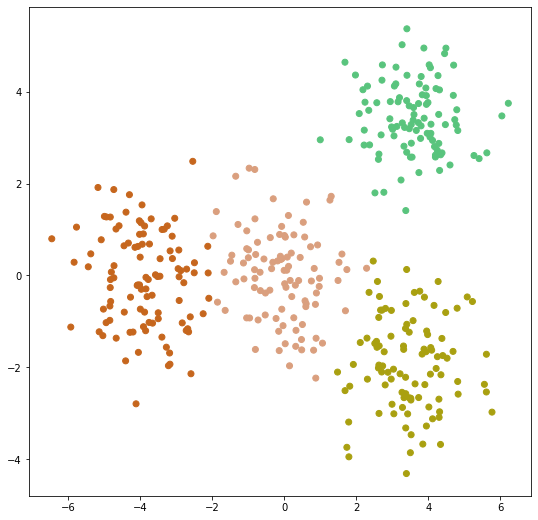

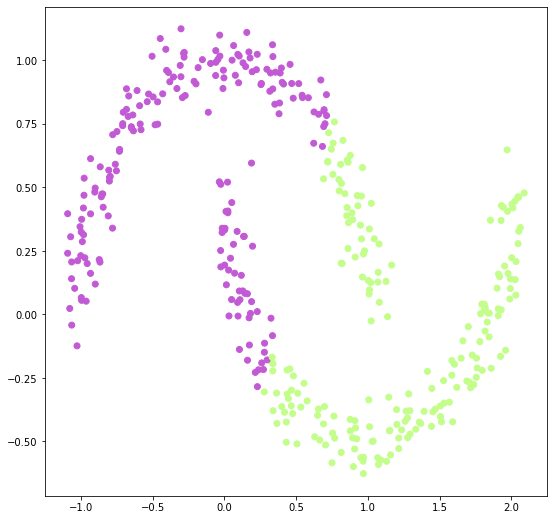

In [16]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### 2. DBScan (3.5 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [17]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "euclidean"):
        """

        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.leaf_size = leaf_size
        self.EMPTY_CLUSTER = -1

    def _dfs_clusters(self, num_cluster, num_clusters, neighbors, is_core_samples, idx_point):
        """
        Returns indices for this cluster
        """

        num_clusters[idx_point] = num_cluster
        for idx in neighbors[idx_point]:
            if num_clusters[idx] == self.EMPTY_CLUSTER:
                if is_core_samples[idx]:
                    self._dfs_clusters(num_cluster, num_clusters, neighbors, is_core_samples, idx)
                else:  # boundary point
                    num_clusters[idx] = num_cluster

    def _get_clusters(self, is_core_samples, neighbors):
        point_count = np.size(is_core_samples, axis=0)
        num_clusters = np.empty(point_count)

        num_clusters.fill(self.EMPTY_CLUSTER)
        num_cluster = 0
        for idx in range(point_count):
            if is_core_samples[idx] and num_clusters[idx] == self.EMPTY_CLUSTER:
                self._dfs_clusters(num_cluster, num_clusters, neighbors, is_core_samples, idx)
                num_cluster += 1

        num_empty_clusters = num_clusters[num_clusters == self.EMPTY_CLUSTER].size
        num_clusters[num_clusters == self.EMPTY_CLUSTER] = np.arange(num_empty_clusters) + num_cluster



        return num_clusters

    def _get_core_samples(self, X: np.array, tree: KDTree) -> np.array:
        """
        Returns points of X which is core samples
        """
        neighbors_distances, neighbors = tree.query(X, k=self.min_samples, return_distance=True)
        is_core_samples = np.max(neighbors_distances, axis=1) < self.eps
        return neighbors, is_core_samples

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        tree = KDTree(X, self.leaf_size, self.metric)
        neighbors, is_core_samples = self._get_core_samples(X, tree)

        return np.array(self._get_clusters(is_core_samples, neighbors), dtype=int)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

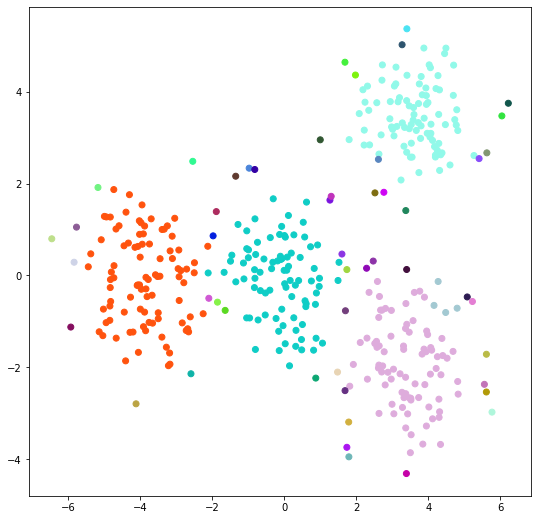

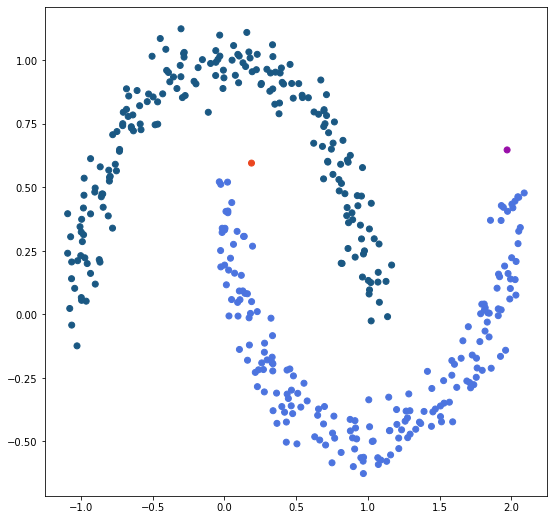

In [18]:
dbscan = DBScan(eps=0.7, min_samples=10)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=15)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### 3. Оценка качества моделей (1 балл)
Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

_Ваш ответ:_ Чем меньше `Davies-Bouldin index`, тем лучше была проведена кластеризация. `Silhouette score`: лучшее значение этого скора 1, худшее (-1); значения, близкие к 0, указывают на перекрывающиеся кластеры, а отрицательные значения обычно указывают на то, что выборка была отнесена к неправильному кластеру, поскольку другой кластер более похож.

Как видно из визуализации: метод `Kmeans` лучше кластеризует первый датасет, а `DBSCAN` -- второй.

`KMeans` плохо справляется со вторым датасетом, т.к. он относит точки к кластерам в зависимости от расстояния до центроидов, в независимости от общего положения точек друг относительно друга; а в данном датасете не существует такой точки(центроида), который был центром для 1-го и 2-го кластеров, что не скажешь про случай с 1-м датасетом, где кластера имеют явную форму круга.

`DBSCAN` не лучшим образом справляется с 1-м датасетом, т.к. в нём присутствуют много точек, удаленных от всех остальных. Таким образом, они не могут отнесены ни к одному из кластеров 


Некоторые метрики показывают противоречивые выводам результаты из-за особенностей вычисления этих метрик (разное количество кластеров, разные расстояния между центрами кластеров).

Вывод: все метрики, кроме внешней, являются в некотором смысле субъективными,
то есть помогают обезопасить от совсем плохого разделения на кластеры, но не факт, что лучшее
значение метрики достигается на действительно оптимальном разделении на кластеры.

In [19]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [20]:
def print_scores(X, labels):
    print(f'Davies-Bouldin score: {davies_bouldin_score(X, labels)}')
    print(f'Silhouette score: {silhouette_score(X, labels)}')

In [21]:
def print_dbscan_scores(X, eps, min_samples):
    dbscan = DBScan(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    print_scores(X, labels)

In [22]:
def print_kmeans_scores(X, n_clusters, init):
    kmeans = KMeans(n_clusters=n_clusters, init=init)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    print_scores(X, labels)

In [23]:
print("KMeans results: \n")
print("First dataset:")
print_kmeans_scores(X_1, n_clusters=4, init="sample")
print("\nSecond dataset:")
print_kmeans_scores(X_2, n_clusters=2, init="sample")

KMeans results: 

First dataset:
Davies-Bouldin score: 0.5733933679583927
Silhouette score: 0.5779684491637334

Second dataset:
Davies-Bouldin score: 0.7879984088102756
Silhouette score: 0.4814689805731143


In [24]:
print("DBSCAN results: \n")
print("First dataset:")
print_dbscan_scores(X_1, eps=0.7, min_samples=10)
print("\nSecond dataset:")
print_dbscan_scores(X_2, eps=0.2, min_samples=15)

DBSCAN results: 

First dataset:
Davies-Bouldin score: 0.4915001214800907
Silhouette score: -0.14564741396387126

Second dataset:
Davies-Bouldin score: 2.2929964090351604
Silhouette score: -0.17000371942080478
